In [1]:
using Geant4
using Geant4.SystemOfUnits
using Geant4.SystemOfUnits: cm3
#using GLMakie, Rotations, IGLWrap_jll  # to force loding G4Vis extension
using CairoMakie
using GeometryBasics, Rotations, IGLWrap_jll

## Functions

In [2]:
function findrdir()
	nbdir = split(@__DIR__,"/")
	reduce(string, [string(x,"/") for x in nbdir[1:end-1]])
end

findrdir (generic function with 1 method)

In [3]:
#---Draw functions---------------------------------------------------------------------------------
function drawdetector!(s, app)
    world = GetWorldVolume()
    #fig = Figure(resolution=(1024,1024))
    #s = LScene(fig[1,1])
    Geant4.draw!(s, world, wireframe=true)
    
    #display(fig)
    return s
end

function drawevent!(s, app, verbose=2)
    data = app.simdata[1]
    if verbose > 0
        println("Run info: Particle =", data.fParticle, 
                " Ekin = ", data.fEkin,
                " Edep = ", data.fEdep)
    end
    for t in data.tracks
        if t.particle == "gamma"
            if verbose > 1
                println(" gamma: energy = ", t.energy, " trkid =", t.trkid, " edep =", t.edep, 
                        " nof points = ", length(t.points), " points: = ", t.points)
                scatter!(s, t.points, markersize=7, color=:blue)
            end
        elseif t.particle == "e-"
            if verbose > 1
                println(" e-: energy = ", t.energy, " trkid =", t.trkid, " edep =", t.edep,
                    " nof points = ", length(t.points), " points: = ", t.points)
            end
            scatter!(s, t.points, markersize=7, color=:red)
        end
        
    end
end

function run1(app; nrun=100)
    EDEP = zeros(nrun)
    nout = 0
    data = app.simdata[1]
    
    for i in 1:nrun
        beamOn(app,1)
        if data.trigger 
            nout+=1
        else
            data = app.simdata[1]
            EDEP[i] = data.fEdep
        end
    end
    EDEP
end

function nexttrigger(app)
    data = app.simdata[1]
    beamOn(app,1)
    n = 1
    while data.trigger
        beamOn(app,1)
        n += 1
    end
    println("Got a trigger after $n generated particles")
end

nexttrigger (generic function with 1 method)

In [4]:
srcdir = string(findrdir(), "src")
include(joinpath(srcdir, "crstDet.jl"))
include(joinpath(srcdir, "crstSimData.jl"))
include(joinpath(srcdir, "crstUserActions.jl"))

stepaction!

## Application

### Define LYSO, BGO and CSI

In [5]:
crlyso = CrstDetector(checkOverlaps=true, crstXY=3.5mm, crstZ=10.0mm, crstName="LYSO")

CrstDetector(true, 3.5, 10.0, "LYSO", CxxPtr{G4Material}(Ptr{G4Material} @0x000000012ce9e070))

In [6]:
crlbgo = CrstDetector(checkOverlaps=true, crstXY=3.5mm, crstZ=10.0mm, crstName="BGO")

CrstDetector(true, 3.5, 10.0, "BGO", CxxPtr{G4Material}(Ptr{G4Material} @0x0000000281204080))

In [7]:
crlcsi = CrstDetector(checkOverlaps=true, crstXY=3.5mm, crstZ=10.0mm, crstName="CSI")

CrstDetector(true, 3.5, 10.0, "CSI", CxxPtr{G4Material}(Ptr{G4Material} @0x0000000281304230))

In [33]:
crlcsi20 = CrstDetector(checkOverlaps=true, crstXY=3.5mm, crstZ=20.0mm, crstName="CSI20")

CrstDetector(true, 3.5, 20.0, "CSI20", CxxPtr{G4Material}(Ptr{G4Material} @0x0000000281304230))

### Define Particle Gun

In [9]:
particlegun = G4JLGunGenerator(particle = "gamma", 
                               energy = 511keV, 
                               direction = G4ThreeVector(0,0,1), 
                               position = G4ThreeVector(0,0,-crlyso.crstZ/2))

G4JLGunGenerator("ParticleGun", Geant4.G4JLParticleGunData(nothing, "gamma", G4ThreeVector(0.0,0.0,1.0), G4ThreeVector(0.0,0.0,-5.0), 0.511), Geant4.var"#init#23"(), Geant4.var"#gen#24"(), G4JLGeneratorAction[])

### Define the application (initially with LYSO as detector)

In [11]:
app = G4JLApplication(; detector = crlyso,                             # detector with parameters
                        simdata = CrstSimData(),                     # simulation data structure
                        generator = particlegun,                      # primary particle generator
                        nthreads = 0,                                 # # of threads (0 = no MT)
                        physics_type = QBBC,                          # what physics list to instantiate
                        stepaction_method = stepaction!,               # step action method
                        begineventaction_method = beginevent!,         # begin-event action (initialize per-event data)
                        #endeventaction_method = endevent,             # end-event action (extract data post-event)
                        pretrackaction_method = pretrackaction!,       # pre-tracking action
                        posttrackaction_method = posttrackaction!,     # post-tracking action
                        beginrunaction_method = beginrun!              # begin run action
                      );


**************************************************************
 Geant4 version Name: geant4-11-01-patch-01 [MT]   (10-February-2023)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************



In [12]:
configure(app)

In [13]:
initialize(app)

Checking overlaps for volume CRYSTAL:0 (G4Box) ... OK! 


#### Draw an event

In [14]:
nexttrigger(app)

Got a trigger after 3 generated particles


Run info: Particle =gamma Ekin = 0.511 Edep = 0.511
 gamma: energy = 0.511 trkid =1 edep =[0.0, 0.0, 0.06332] nof points = 4 points: = Point3{Float64}[[0.0, 0.0, -5.0], [0.0, 0.0, -4.114552706928433], [0.09104438672190633, 0.04433689580944583, -3.9436425669309503], [-0.37075841939208576, -0.3162253451339098, -4.4249462149289425]]
 e-: energy = 0.10307302141325912 trkid =4 edep =[0.10307302141325912] nof points = 2 points: = Point3{Float64}[[-0.37075841939208576, -0.3162253451339098, -4.4249462149289425], [-0.3697150272555448, -0.3196814308395525, -4.4235626276598445]]
 e-: energy = 0.28197920338534943 trkid =3 edep =[0.28197920338534943] nof points = 2 points: = Point3{Float64}[[0.09104438672190633, 0.04433689580944583, -3.9436425669309503], [0.10045780742467819, 0.04983448490397095, -3.9285676195185437]]
 e-: energy = 0.06262777520139146 trkid =2 edep =[0.06262777520139146] nof points = 2 points: = Point3{Float64}[[0.0, 0.0, -4.114552706928433], [-0.0013840792799380856, -0.00067402045

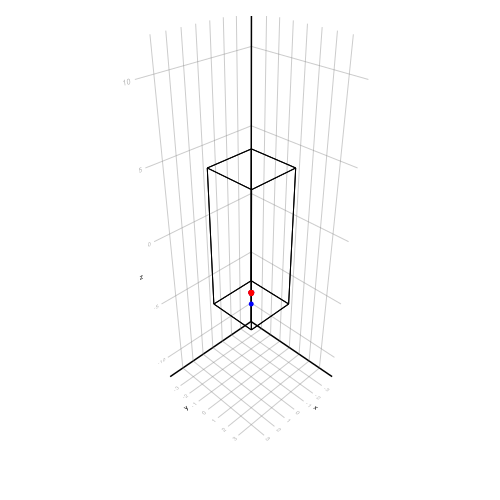

CairoMakie.Screen{IMAGE}


In [15]:
fig = Figure(resolution=(500,500))
s = LScene(fig[1,1])
drawdetector!(s, app)
drawevent!(s, app)
display(fig)

#### LYSO edep

In [17]:
edep = run1(app; nrun=50000);

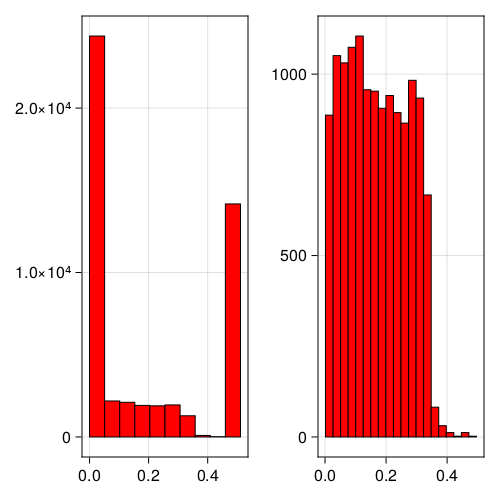

In [18]:
f = Figure(resolution=(500,500))
hist(f[1,1],edep, bins = 10, color = :red, strokewidth = 1, strokecolor = :black)
hist(f[1,2],filter(x->x>0 && x < 0.510, edep), bins = 20, color = :red, strokewidth = 1, strokecolor = :black)
f

In [19]:
println("Fraction of events that interact in crystal = ", length(filter(x->x > 0, edep)) /length(edep))

Fraction of events that interact in crystal = 0.55114


In [20]:
println("Fraction of events in photopeak = ", length(filter(x->x > 0.509, edep)) /length(edep))

Fraction of events in photopeak = 0.28336


### BGO case

In [21]:
reinitialize(app, crlbgo)

Checking overlaps for volume CRYSTAL:0 (G4Box) ... OK! 


In [22]:
nexttrigger(app)

Got a trigger after 2 generated particles


Run info: Particle =gamma Ekin = 0.511 Edep = 0.511
 gamma: energy = 0.511 trkid =1 edep =[0.0, 0.090534] nof points = 3 points: = Point3{Float64}[[0.0, 0.0, -5.0], [0.0, 0.0, -0.9542137857593662], [-0.023103664956601544, -0.8300430618710622, -1.0178785829725105]]
 e-: energy = 0.15555922979838657 trkid =3 edep =[0.15555922979838657] nof points = 2 points: = Point3{Float64}[[-0.023103664956601544, -0.8300430618710622, -1.0178785829725105], [-0.02245508092043765, -0.8369266294686865, -1.016139071732241]]
 e-: energy = 0.26490677020161346 trkid =2 edep =[0.26490677020161346] nof points = 2 points: = Point3{Float64}[[0.0, 0.0, -0.9542137857593662], [0.0001868695360154583, 0.0067136431443261275, -0.9397119796783614]]


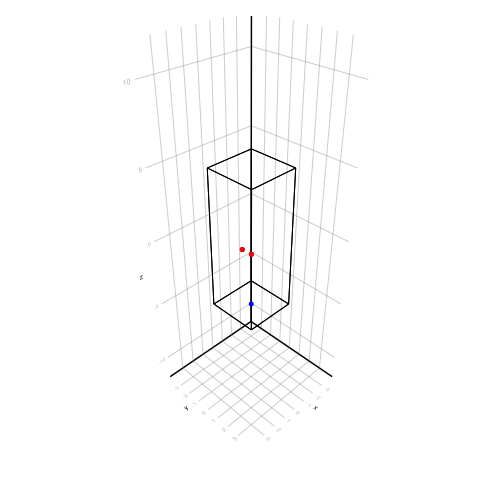

CairoMakie.Screen{IMAGE}


In [23]:
fig = Figure(resolution=(500,500))
s = LScene(fig[1,1])
drawdetector!(s, app)
drawevent!(s, app)
display(fig)

In [24]:
edep = run1(app; nrun=50000);

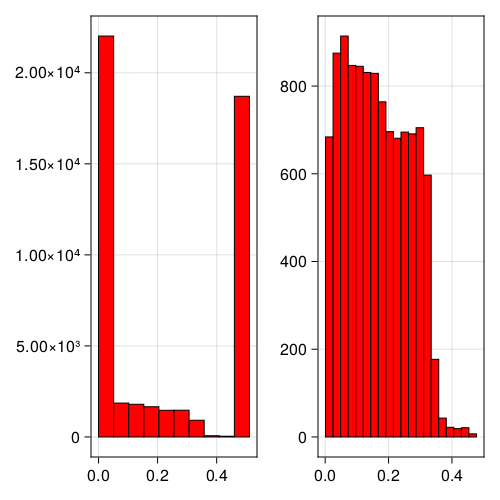

In [25]:
f = Figure(resolution=(500,500))
hist(f[1,1],edep, bins = 10, color = :red, strokewidth = 1, strokecolor = :black)
hist(f[1,2],filter(x->x>0 && x < 0.510, edep), bins = 20, color = :red, strokewidth = 1, strokecolor = :black)
f

In [26]:
println("Fraction of events that interact in crystal = ", length(filter(x->x > 0, edep)) /length(edep))

Fraction of events that interact in crystal = 0.59294


In [27]:
println("Fraction of events in photopeak = ", length(filter(x->x > 0.509, edep)) /length(edep))

Fraction of events in photopeak = 0.37408


### CsI

In [28]:
reinitialize(app, crlcsi)

Checking overlaps for volume CRYSTAL:0 (G4Box) ... OK! 


In [29]:
edep = run1(app; nrun=50000);

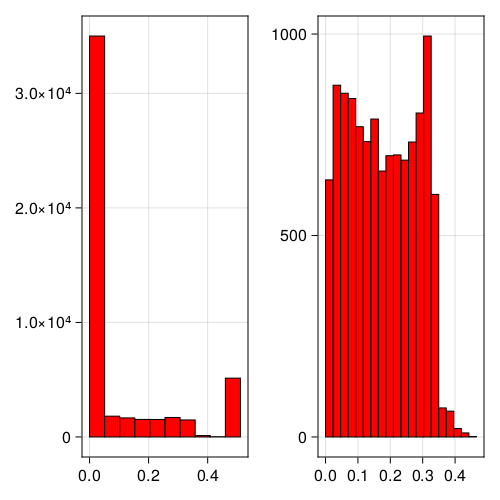

In [30]:
f = Figure(resolution=(500,500))
hist(f[1,1],edep, bins = 10, color = :red, strokewidth = 1, strokecolor = :black)
hist(f[1,2],filter(x->x>0 && x < 0.510, edep), bins = 20, color = :red, strokewidth = 1, strokecolor = :black)
f

In [31]:
println("Fraction of events that interact in crystal = ", length(filter(x->x > 0, edep)) /length(edep))

Fraction of events that interact in crystal = 0.33352


In [32]:
println("Fraction of events in photopeak = ", length(filter(x->x > 0.509, edep)) /length(edep))

Fraction of events in photopeak = 0.10268


### CSI with 20 cm X0

In [34]:
reinitialize(app, crlcsi20) 

Checking overlaps for volume CRYSTAL:0 (G4Box) ... OK! 


In [35]:
edep = run1(app; nrun=50000);

In [36]:
println("Fraction of events that interact in crystal = ", length(filter(x->x > 0, edep)) /length(edep))

Fraction of events that interact in crystal = 0.45442


In [37]:
println("Fraction of events in photopeak = ", length(filter(x->x > 0.509, edep)) /length(edep))

Fraction of events in photopeak = 0.14506


In [38]:
for i in 1:3
    println(i)
end

1
2
3
